# Trainerを使ってみよう

`Trainer`を使うと学習ループを明示的に書く必要がなくなり、またいろいろな便利なExtentionを使うことで可視化やログの保存などが楽になります。

## 1. データセットの準備

In [1]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

## 2. Iteratorの準備

In [2]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

## 3. Modelの準備

In [3]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__(
            # the size of the inputs to each layer will be inferred
            l1=L.Linear(None, n_mid_units),  # n_in -> n_units
            l2=L.Linear(None, n_mid_units),  # n_units -> n_units
            l3=L.Linear(None, n_out),  # n_units -> n_out
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0

model = MLP()
model.to_gpu(gpu_id)

## 4. Updaterの準備

Trainerは学習に必要な全てのものをひとまとめにするクラスです。それは主に以下のようなものを保持します。

- Updater
    - Iterator
    - Optimizer
        - Model

`Trainer`オブジェクトを作成するときに渡すのは基本的に`Updater`だけですが、`Updater`は中に`Iterator`と`Optimizer`を持っています。`Iterator`からはデータセットにアクセスすることができ、`Optimizer`は中でモデルへの参照を保持しているので、モデルのパラメータを更新することができます。つまり、`Updater`が内部で

1. データセットからデータを取り出し
2. モデルに渡してロスを計算し
3. Optimizerを使ってモデルのパラメータを更新する

という一連の学習の主要部分を行うことができるということです。では、`Updater`オブジェクトを作成してみます。

In [4]:
from chainer import optimizers
from chainer import training

max_epoch = 10
gpu_id = 0

# モデルをClassifierで包んで、ロスの計算などをモデルに含める
model = L.Classifier(model)
model.to_gpu(gpu_id)

# 最適化手法の選択
optimizer = optimizers.SGD()
optimizer.setup(model)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

## 5. Trainerの設定

最後に、`Trainer`の設定を行います。`Trainer`のオブジェクトを作成する際に必須となるのは、先程作成した`Updater`オブジェクトだけですが、二番目の引数`stop_trigger`に学習をどのタイミングで終了するかを指定する`(長さ, 単位)`という形のタプルを与えると、指定したタイミングで学習を自動的に終了することができます。長さには任意の整数、単位には`'epoch'`か`'iteration'`のいずれかの文字列を指定できます。`stop_trigger`を指定しない場合、学習は自動的には止まりません。

In [5]:
# TrainerにUpdaterを渡す
trainer = training.Trainer(updater, (max_epoch, 'epoch'),
                           out='mnist_result')

`out`引数では、この次に説明する`Extension`を使って、ログファイルやロスの変化の過程を描画したグラフの画像ファイルなどを保存するディレクトリを指定しています。

## 6. TrainerにExtensionを追加する


`Trainer`を使う利点として、

- ログを自動的にファイルに保存（`LogReport`)
- ターミナルに定期的にロスなどの情報を表示（`PrintReport`）
- ロスを定期的にグラフで可視化して画像として保存（`PlotReport`)
- 定期的にモデルやOptimizerの状態を自動シリアライズ（`snapshot`/`snapshot_object`）
- 学習の進捗を示すプログレスバーを表示（`ProgressBar`）
- モデルの構造をGraphvizのdot形式で保存（`dump_graph`）

などなどの様々な便利な機能を簡単に利用することができる点があります。これらの機能を利用するには、`Trainer`オブジェクトに対して`extend`メソッドを使って追加したい`Extension`のオブジェクトを渡してやるだけです。では実際に幾つかの`Extension`を追加してみましょう。

In [6]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'main/accuracy'], x_key='epoch', file_name='train_plot.png'))
trainer.extend(extensions.PlotReport(['validation/main/loss', 'validation/main/accuracy'], x_key='epoch', file_name='test_plot.png'))

### `LogReport`

`epoch`や`iteration`ごとの`loss`, `accuracy`などを自動的に集計し、`Trainer`の`out`引数で指定した出力ディレクトリに`log`というファイル名で保存します。

### `snapshot`

`Trainer`の`out`引数で指定した出力ディレクトリに`Trainer`オブジェクトを指定されたタイミング（デフォルトでは1エポックごと）に保存します。`Trainer`オブジェクトは上述のように`Updater`を持っており、この中に`Optimizer`とモデルが保持されているため、この`Extension`でスナップショットをとっておけば、学習の復帰や学習済みモデルを使った推論などが学習終了後にも可能になります。

### `snapshot_object`

`Trainer`ごと保存した場合、しばしば中身のモデルだけ取り出すのが面倒な場合があります。そこで、`snapshot_object`と使って指定したオブジェクト（ここでは`Classifier`で包まれたモデル）だけを、`Trainer`とは別に保存するようにします。`Classifier`は第1引数に渡された`Chain`オブジェクトを自身の`predictor`というプロパティとして保持しており、`Classifier`はそもそもパラメータを持たないので、ここでは後々学習済みモデルを推論に使うことを見越して`model.predictor`を保存対象として指定しています。

### `dump_graph`

指定された`Variable`オブジェクトから辿れる計算グラフをGraphvizのdot形式で保存します。保存先は`Trainer`の`out`引数で指定した出力ディレクトリです。

### `Evaluator`

評価用のデータセットの`Iterator`と、学習に使うモデルのオブジェクトを渡しておくことで、学習中のモデルを指定されたタイミングで評価用データセットを用いて評価します。

### `PrintReport`

`Reporter`によって集計された値を標準出力に出力します。このときどの値を出力するかを、リストの形で与えます。

### `PlotReport`

引数のリストで指定された値の変遷を`matplotlib`ライブラリを使ってグラフに描画し、出力ディレクトリに`file_name`引数で指定されたファイル名で画像として保存します。

---

これらの`Extension`は、ここで紹介した以外にも、例えば`trigger`によって個別に作動するタイミングを指定できるなどのいくつかのオプションを持っており、より柔軟に組み合わせることができます。詳しくは公式のドキュメントを見てください：[Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)。

## 7. 学習を開始する

学習を開始するには、`Trainer`オブジェクトのメソッド`run`を呼ぶだけです。

In [7]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.53571     0.611607       0.773428              0.828521                  2.99358       
2           0.585717    0.856793       0.444285              0.885977                  5.43161       
3           0.418647    0.887044       0.363637              0.900514                  7.91196       
4           0.361536    0.899005       0.325456              0.909316                  10.433        
5           0.329784    0.906616       0.300519              0.91426                   12.9301       
6           0.308143    0.912114       0.285303              0.919403                  15.547        
7           0.291611    0.916794       0.269441              0.923358                  17.9965       
8           0.277818    0.920656       0.258188              0.925633                  20.5027       
9           0.265705    0.923757       0.249505              0.926622               

保存されているグラフを確認してみましょう。（Jupyter notebookのmarkdownモードのセルで、`![](mnist_results/train_plot.png)`とやると以下のように画像として表示されます。）
![](mnist_result/train_plot.png)
テストデータに対するロスと精度のグラフも見てみましょう。
![](mnist_result/test_plot.png)

## 8. 学習済みモデルで推論する

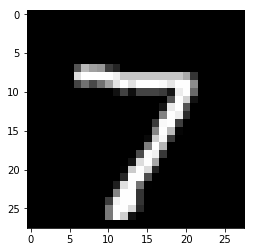

label: 7
predicted_label: 7


In [8]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)
model.to_gpu(gpu_id)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

x = to_gpu(x[None, ...])
y = model(x)
y = to_cpu(y.data)

print('predicted_label:', y.argmax(axis=1)[0])